In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


Titanic data:

* PassengerId: Mã hàng khách. Đây được xem là chỉ mục của bảng dữ liệu.
* Pclass: Hạng vé tàu của hàng khách.
* Sex: Giới tính của hàng khách.
* Age: Tuổi của hàng khách.
* SibSp: Số lượng anh chị em và/hoặc người yêu đi cùng chuyến tàu với hàng
khách.
* Parch: Số lượng phụ huynh và/hoặc con cháu đi cùng chuyến tàu với hàng khách.
* Fare: Giá vé tàu của hàng khách.
* Embarked: Cảng xuất phát của hàng khách.
* Title: Tước hiệu của hàng khách.
* Survived: Hàng khách có (1) sống sót qua thảm kịch hay không (0)?

In [2]:
dataset_path = '/content/titanic_modified_dataset.csv'
df = pd.read_csv(dataset_path, index_col='PassengerId')
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Survived
PassengerId,,,,,,,,,
1,3,0,22.0,1,0,7.2500,0,0,0
2,1,1,38.0,1,0,71.2833,1,1,1
3,3,1,26.0,0,0,7.9250,0,2,1
4,1,1,35.0,1,0,53.1000,0,1,1
5,3,0,35.0,0,0,8.0500,0,0,0


# Split X, y from data

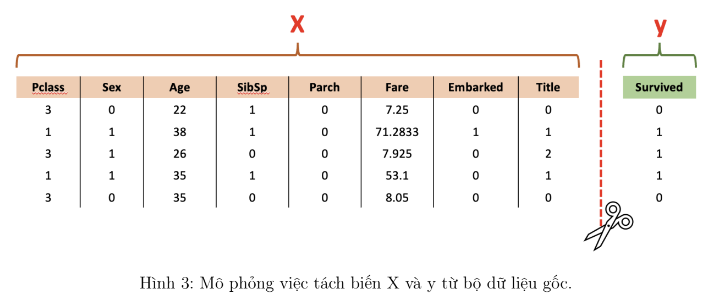

In [3]:
# Split data to array and split into X, y
dataset_arr = df.to_numpy().astype(np.float64)
X, y = dataset_arr[:, :-1], dataset_arr[:, -1]

# Add bias into X set

In [4]:
# Add bias into X
intercept = np.ones((X.shape[0], 1))
X_b = np.concatenate((intercept, X), axis=1)

# Split train, val, test dataset

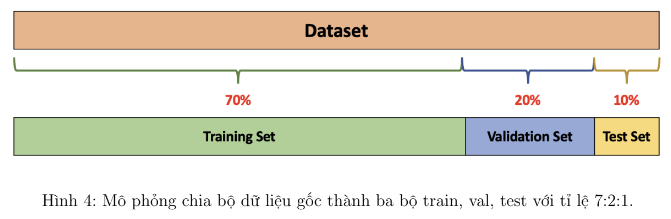

In [5]:
# Split data into train and test set
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True
X_train, X_val, y_train, y_val = train_test_split(X_b, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle)


# Standard data
Ta sử dụng X_train vừa tạo ở bước trên fit vào hàm chuẩn hóa StandardScaler. Sau đó, đem scaler này chuẩn hóa cho tập X_val và X_test (lưu ý rằng ta không chuẩn hóa bias nên sẽ bỏ qua cột đầu tiên trong X):

In [6]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.fit_transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.fit_transform(X_test[:, 1:])

# Implement importance functions

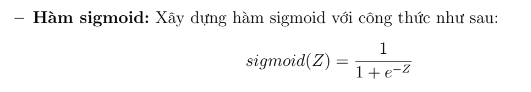

In [7]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))


In [8]:
def predict(X, theta):
  dot_product = np.dot(X, theta)
  y_hat = sigmoid(dot_product)

  return y_hat

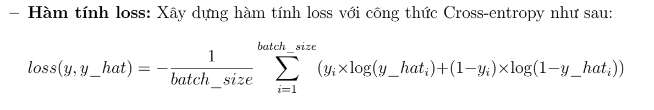

In [9]:
def compute_loss(y_hat, y):
  y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)

  return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()

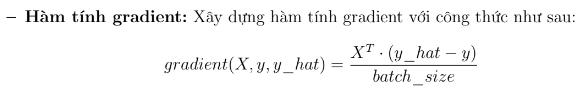

In [10]:
def compute_gradient(X, y, y_hat):
  return np.dot(X.T, (y_hat - y)) / y.size

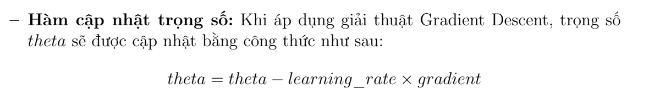

In [11]:
def update_theta(theta, gradient, lr):
  return theta - lr * gradient

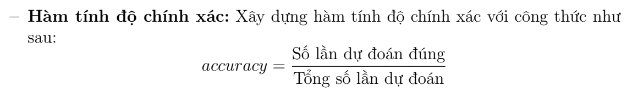

In [12]:
def compute_accuracy(X, y, theta):
  y_hat = predict(X, theta).round()
  acc = (y_hat == y).mean()
  return acc

# Init parameters

In [13]:
lr = 0.01
epochs = 100
batch_size = 16

np.random.seed(random_state)
theta = np.random.uniform(size=X_train.shape[1])

# Training model


Khởi tạo vòng lặp với số lần lặp bằng số epochs. Với mỗi lần lặp, duyệt qua toàn bộ mẫu dữ liệu (trong training set) theo từng bộ mẫu dữ liệu có kích thước **batch_size** (tạm gọi là cặp **X_i** và **y_i**) và thực hiện các bước tính toán sau:
* (a) Tính **y_hat** sử dụng hàm **predict(X_i, theta)**. Đây là kết quả dự đoán của mô hình với các mẫu dữ liệu tại batch đang xét.
* (b) Tính **loss** sử dụng hàm **compute_loss(y_hat, y_i)**. Lưu trữ giá trị này vào một list **batch_losses**, dùng cho việc trực quan hóa kết quả huấn luyện sau này.
* (c) Tính **gradient** sử dụng hàm **compute_gradient(X_i, y_i, y_hat)**.
* (d) Sử dụng kết quả gradient vừa tìm được để cập nhật bộ trọng số **theta** sử dụng hàm **update_theta(theta, gradient, lr)**.

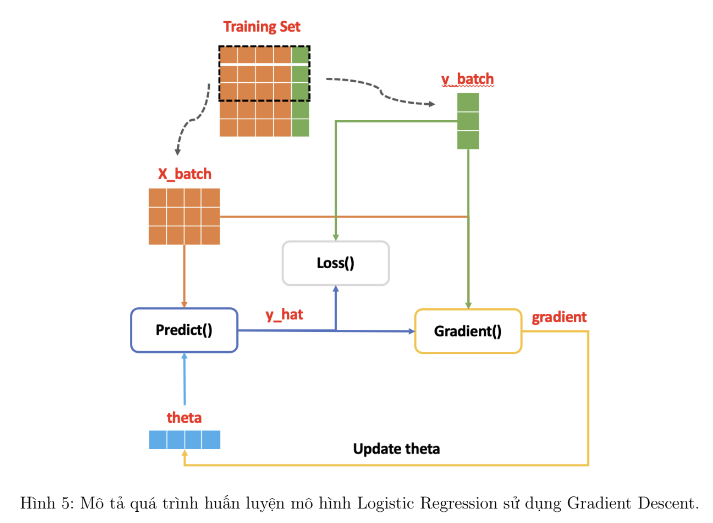

In [14]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
  train_batch_losses = []
  train_batch_accs = []
  val_batch_losses = []
  val_batch_accs = []

  for i in range(0, X_train.shape[0], batch_size):
    X_i = X_train[i:i+batch_size]
    y_i = y_train[i:i+batch_size]

    # Forward on train data
    y_hat = predict(X_i, theta)
    train_loss = compute_loss(y_hat, y_i)

    # Backward propagation
    gradient = compute_gradient(X_i, y_i, y_hat)
    theta = update_theta(theta, gradient, lr)

    train_batch_losses.append(train_loss)
    train_acc = compute_accuracy(X_train, y_train, theta)
    train_batch_accs.append(train_acc)

    # Apply on validation data
    y_val_hat = predict(X_val, theta)
    val_loss = compute_loss(y_val_hat, y_val)
    val_batch_losses.append(val_loss)

    val_acc = compute_accuracy(X_val, y_val, theta)
    val_batch_accs.append(val_acc)

  train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
  train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
  val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
  val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

  train_losses.append(train_batch_loss)
  train_accs.append(train_batch_acc)
  val_losses.append(val_batch_loss)
  val_accs.append(val_batch_acc)

  print(f'\nEPOCH {epoch + 1}: \tTrainning loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:3f}')


EPOCH 1: 	Trainning loss: 0.703	Validation loss: 0.625784

EPOCH 2: 	Trainning loss: 0.670	Validation loss: 0.603953

EPOCH 3: 	Trainning loss: 0.640	Validation loss: 0.585111

EPOCH 4: 	Trainning loss: 0.614	Validation loss: 0.568915

EPOCH 5: 	Trainning loss: 0.592	Validation loss: 0.555073

EPOCH 6: 	Trainning loss: 0.572	Validation loss: 0.543327

EPOCH 7: 	Trainning loss: 0.554	Validation loss: 0.533439

EPOCH 8: 	Trainning loss: 0.539	Validation loss: 0.525187

EPOCH 9: 	Trainning loss: 0.526	Validation loss: 0.518357

EPOCH 10: 	Trainning loss: 0.514	Validation loss: 0.512752

EPOCH 11: 	Trainning loss: 0.504	Validation loss: 0.508185

EPOCH 12: 	Trainning loss: 0.495	Validation loss: 0.504492

EPOCH 13: 	Trainning loss: 0.487	Validation loss: 0.501530

EPOCH 14: 	Trainning loss: 0.480	Validation loss: 0.499175

EPOCH 15: 	Trainning loss: 0.474	Validation loss: 0.497322

EPOCH 16: 	Trainning loss: 0.468	Validation loss: 0.495886

EPOCH 17: 	Trainning loss: 0.463	Validation loss

# Virtualize data

[Text(0.5, 0, 'Epochs'),
 Text(0, 0.5, 'Accuracy'),
 Text(0.5, 1.0, 'Training Accuracy')]

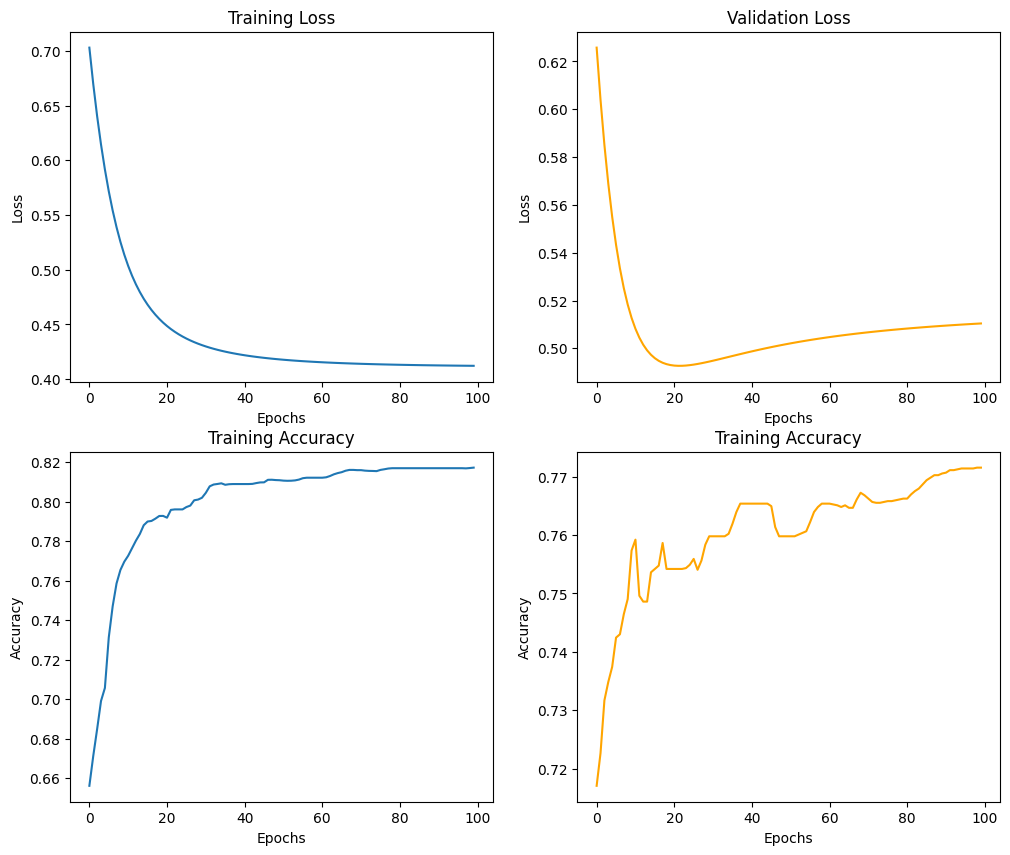

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epochs', ylabel='Loss', title='Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epochs', ylabel='Loss', title='Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epochs', ylabel='Accuracy', title='Training Accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel='Epochs', ylabel='Accuracy', title='Training Accuracy')

# Testing model
Sử dụng bộ trọng số mô hình tìm được sau quá trình huấn luyện, ta đánh giá độ chính xác của mô hình trên hai tập val và test:

In [16]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)

print('Evaluation on validation and test set:')
print(f'Validation set accuracy: {val_set_acc:.3f}')
print(f'Test set accuracy: {test_set_acc:.3f}')

Evaluation on validation and test set:
Validation set accuracy: 0.777
Test set accuracy: 0.775
